The purpose of the project is to try and predict the probability of NFL success for a quarterback. The definition of success is three or more years on an NFL roster.  There will be two techniques used in this project: Logistic Regression, and Random Forests.

The regression will be based on the following explanatory variables:

a. The number of college games started-A quarterback that is an NFL prospect should be the starting quarterback on the team and; therefore, should be playing in more games.  This will give the player more game experience and should make him a better player.  

b. The pass completion percentage-This is the number of passes completed per the number of pass attempts.  This metric accounts for the number of number of pass attempts made each game.  This is important since the number of passes attempted will differ depending on the opponent and on the type of offensive system used by each quarterback.  Some teams rely more on the pass than others.  In addition, the % completion is a measure of quarterback accuracy.  

c. Yards per Attempt-This measures the number of yards gained on a completed forward pass per pass attempt.  A high yds./attempt number suggest that more long passes are being thrown than short passes by a quarterback.  

d. Passer Efficiency Rating-  This is a measure of quarterback efficiency and is given by the following formula:  

$$Eff= \frac {8.4(Yds Gained) + 330 (Num Touchdowns) +100(Pct. Comp) -200(Num Interceptions)}{Num Pass Attempts}$$  

e. Touchdown to Interception Ratio-This measures the decision making ability of a QB since a low TD/INT ratio suggests that a quarterback has a problem reading opponents defensive coverage schemes.  

f. Passing Yards per Game- A measure of passing success in a game.  Usually, a quarterback that throws for a high number of yards per game wins more games than he loses.  Additionally, this is indicative of good decision making as well.  

g. Touchdowns per Attempt-A measure normalizing the number of touchdowns thrown in a season by the number of passes attempted.  

h. Interceptions per attempt- A measure normalizing the number of interceptions thrown in a season by the number of passes attempted.

## Importing packages

In [2]:
import time
import pandas as pd
import numpy as np
import sklearn
import statsmodels.api as sm
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.formula.api import logit, glm
from statsmodels.genmod.generalized_linear_model import GLMResults
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
%matplotlib inline


## Importing Data

Note: Data entered into SQL.  Created Table

In [3]:
QB0005 = pd.read_csv('/home/brianc/McNulty Project/Data/PassingStats20002005.csv')
QB0611 = pd.read_csv('/home/brianc/McNulty Project/Data/PassingStats20062011.csv')
QB0005.rename(columns={'TotGames':'Games'}, inplace=True)
QB0611['CompPct']=QB0611['TotComp']/QB0611['TotAtt']
QB0611 = QB0611[['Last','First','Games','TotAtt','TotComp','TotYds','TotTD','TotInt','PassRt','CompPct','YPAtt','TDPAtt','IntPAtt','YPGm','TDPInt','yr3NFLVet']]
QBall = pd.concat([QB0005,QB0611],axis = 0)
QBall.sort_values(by=['Last','First'])
QBall= QBall.reset_index()
del QBall['index']
QBall.to_csv('QBStats00to11.csv')

In [4]:
#train = QBall.sample(frac=0.8, random_state=1)
#test = QBall.loc[~QBall.index.isin(train.index)]


In [4]:
 sss = StratifiedShuffleSplit(QBall['yr3NFLVet'], 1, test_size=0.2, random_state=0)
for train_indx, test_indx in sss:
    
    train = QBall.ix[train_indx]
    X_train = train[['Games','TotAtt','TotComp','TotYds','TotTD','TotInt','PassRt','CompPct','YPAtt','TDPAtt','IntPAtt','YPGm','TDPInt']]
    y_train = train['yr3NFLVet']
    
    test = QBall.ix[test_indx]
    X_test = test[['Games','TotAtt','TotComp','TotYds','TotTD','TotInt','PassRt','CompPct','YPAtt','TDPAtt','IntPAtt','YPGm','TDPInt']]
    y_test = test['yr3NFLVet']
    

X_trainStd = X_train.apply(lambda x: (x - np.mean(x)) / np.std(x))
X_testStd = X_test.apply(lambda x: (x - np.mean(x)) / np.std(x)) 

train = pd.concat([X_train, y_train],join = 'outer', axis=1)
test =  pd.concat([X_test, y_test],join = 'outer', axis=1)
train_std = pd.concat([X_trainStd, y_train],join = 'outer', axis=1)
test_std = pd.concat([X_testStd, y_train],join = 'outer', axis=1)
    

## Exploratory Data Analysis

Games-No. Games Played  
TotAtt-Total passing attempts  
TotComp-Total Completions  
TotYds-Total Yards passing  
TotTD-Total Touchdowns  
TotInt-Total Interceptions  
PassRt-Passer Rating  
CompPct-Pass Completion Percentage  
YPAtt-Passing yards/Attempt  
TDPAtt-Touchdowns/Attempt  
IntPAtt-Interceptions/Attempt  
YPGm-Yards/Game  
TDPInt-Touchdowns/Interception  
yr3NFLVet-On NFL Roster for Three Years  

In [5]:
train.describe()

,Games,TotAtt,TotComp,TotYds,TotTD,TotInt,PassRt,CompPct,YPAtt,TDPAtt,IntPAtt,YPGm,TDPInt,yr3NFLVet
count,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000
mean,20.021314,580.609236,345.586146,4251.307282,30.017762,17.103020,129.540071,27.978776,7.240551,0.050036,0.031474,203.056998,1.807975,0.174067
std,10.805606,378.063783,237.259804,2890.385606,23.246162,10.404114,15.862998,28.436638,0.907307,0.016294,0.010560,52.099782,1.014043,0.379505
min,9.000000,150.000000,75.000000,879.000000,3.000000,2.000000,85.070000,0.444079,5.050000,0.010000,0.010000,92.100000,0.270000,0.000000
25%,11.000000,294.500000,163.500000,2036.000000,13.000000,9.000000,118.860000,0.597070,6.605000,0.040000,0.020000,166.425000,1.140000,0.000000
50%,13.000000,439.000000,266.000000,3332.000000,23.000000,14.000000,128.130000,0.693046,7.190000,0.050000,0.030000,198.640000,1.590000,0.000000
75%,25.000000,784.000000,462.500000,5623.000000,40.000000,23.000000,138.830000,56.460000,7.830000,0.060000,0.040000,232.125000,2.250000,0.000000
max,54.000000,2296.000000,1499.000000,18535.000000,150.000000,74.000000,182.050000,70.590000,10.190000,0.120000,0.070000,448.690000,8.500000,1.000000


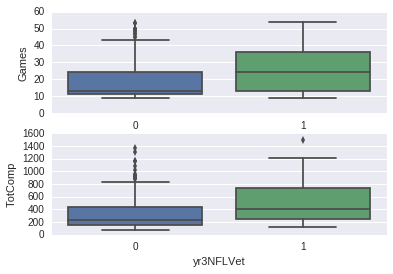

In [20]:
plt.subplot(2,1,1)
sn.boxplot(train['yr3NFLVet'],train['Games'])
plt.subplot(2,1,2)
sn.boxplot(train['yr3NFLVet'],train['TotComp'])


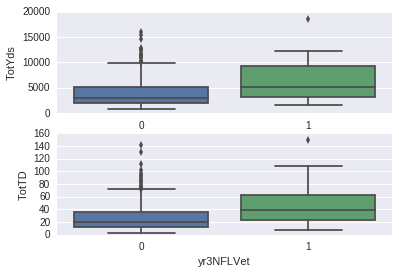

In [21]:
plt.subplot(2,1,1)
sn.boxplot(train['yr3NFLVet'],train['TotYds'])
plt.subplot(2,1,2)
sn.boxplot(train['yr3NFLVet'],train['TotTD'])

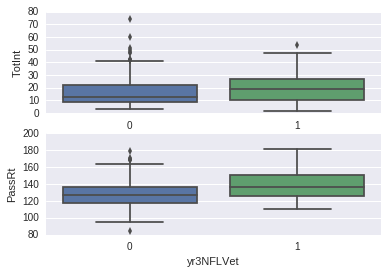

In [22]:
plt.subplot(2,1,1)
sn.boxplot(train['yr3NFLVet'],train['TotInt'])
plt.subplot(2,1,2)
sn.boxplot(train['yr3NFLVet'],train['PassRt'])

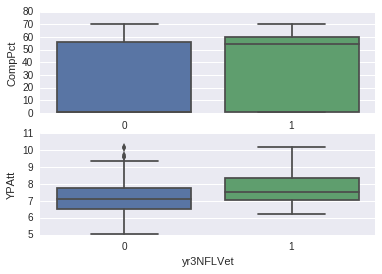

In [34]:
plt.subplot(2,1,1)
sn.boxplot(train['yr3NFLVet'],train['CompPct'])
plt.subplot(2,1,2)
sn.boxplot(train['yr3NFLVet'],train['YPAtt'])

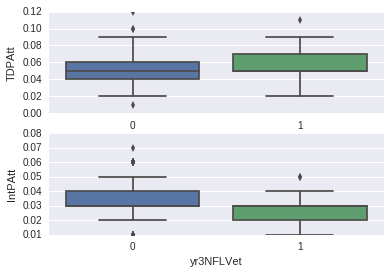

In [35]:
plt.subplot(2,1,1)
sn.boxplot(train['yr3NFLVet'],train['TDPAtt'])
plt.subplot(2,1,2)
sn.boxplot(train['yr3NFLVet'],train['IntPAtt'])

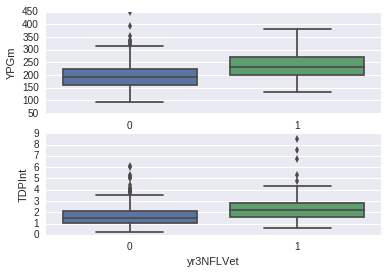

In [36]:
plt.subplot(2,1,1)
sn.boxplot(train['yr3NFLVet'],train['YPGm'])
plt.subplot(2,1,2)
sn.boxplot(train['yr3NFLVet'],train['TDPInt'])

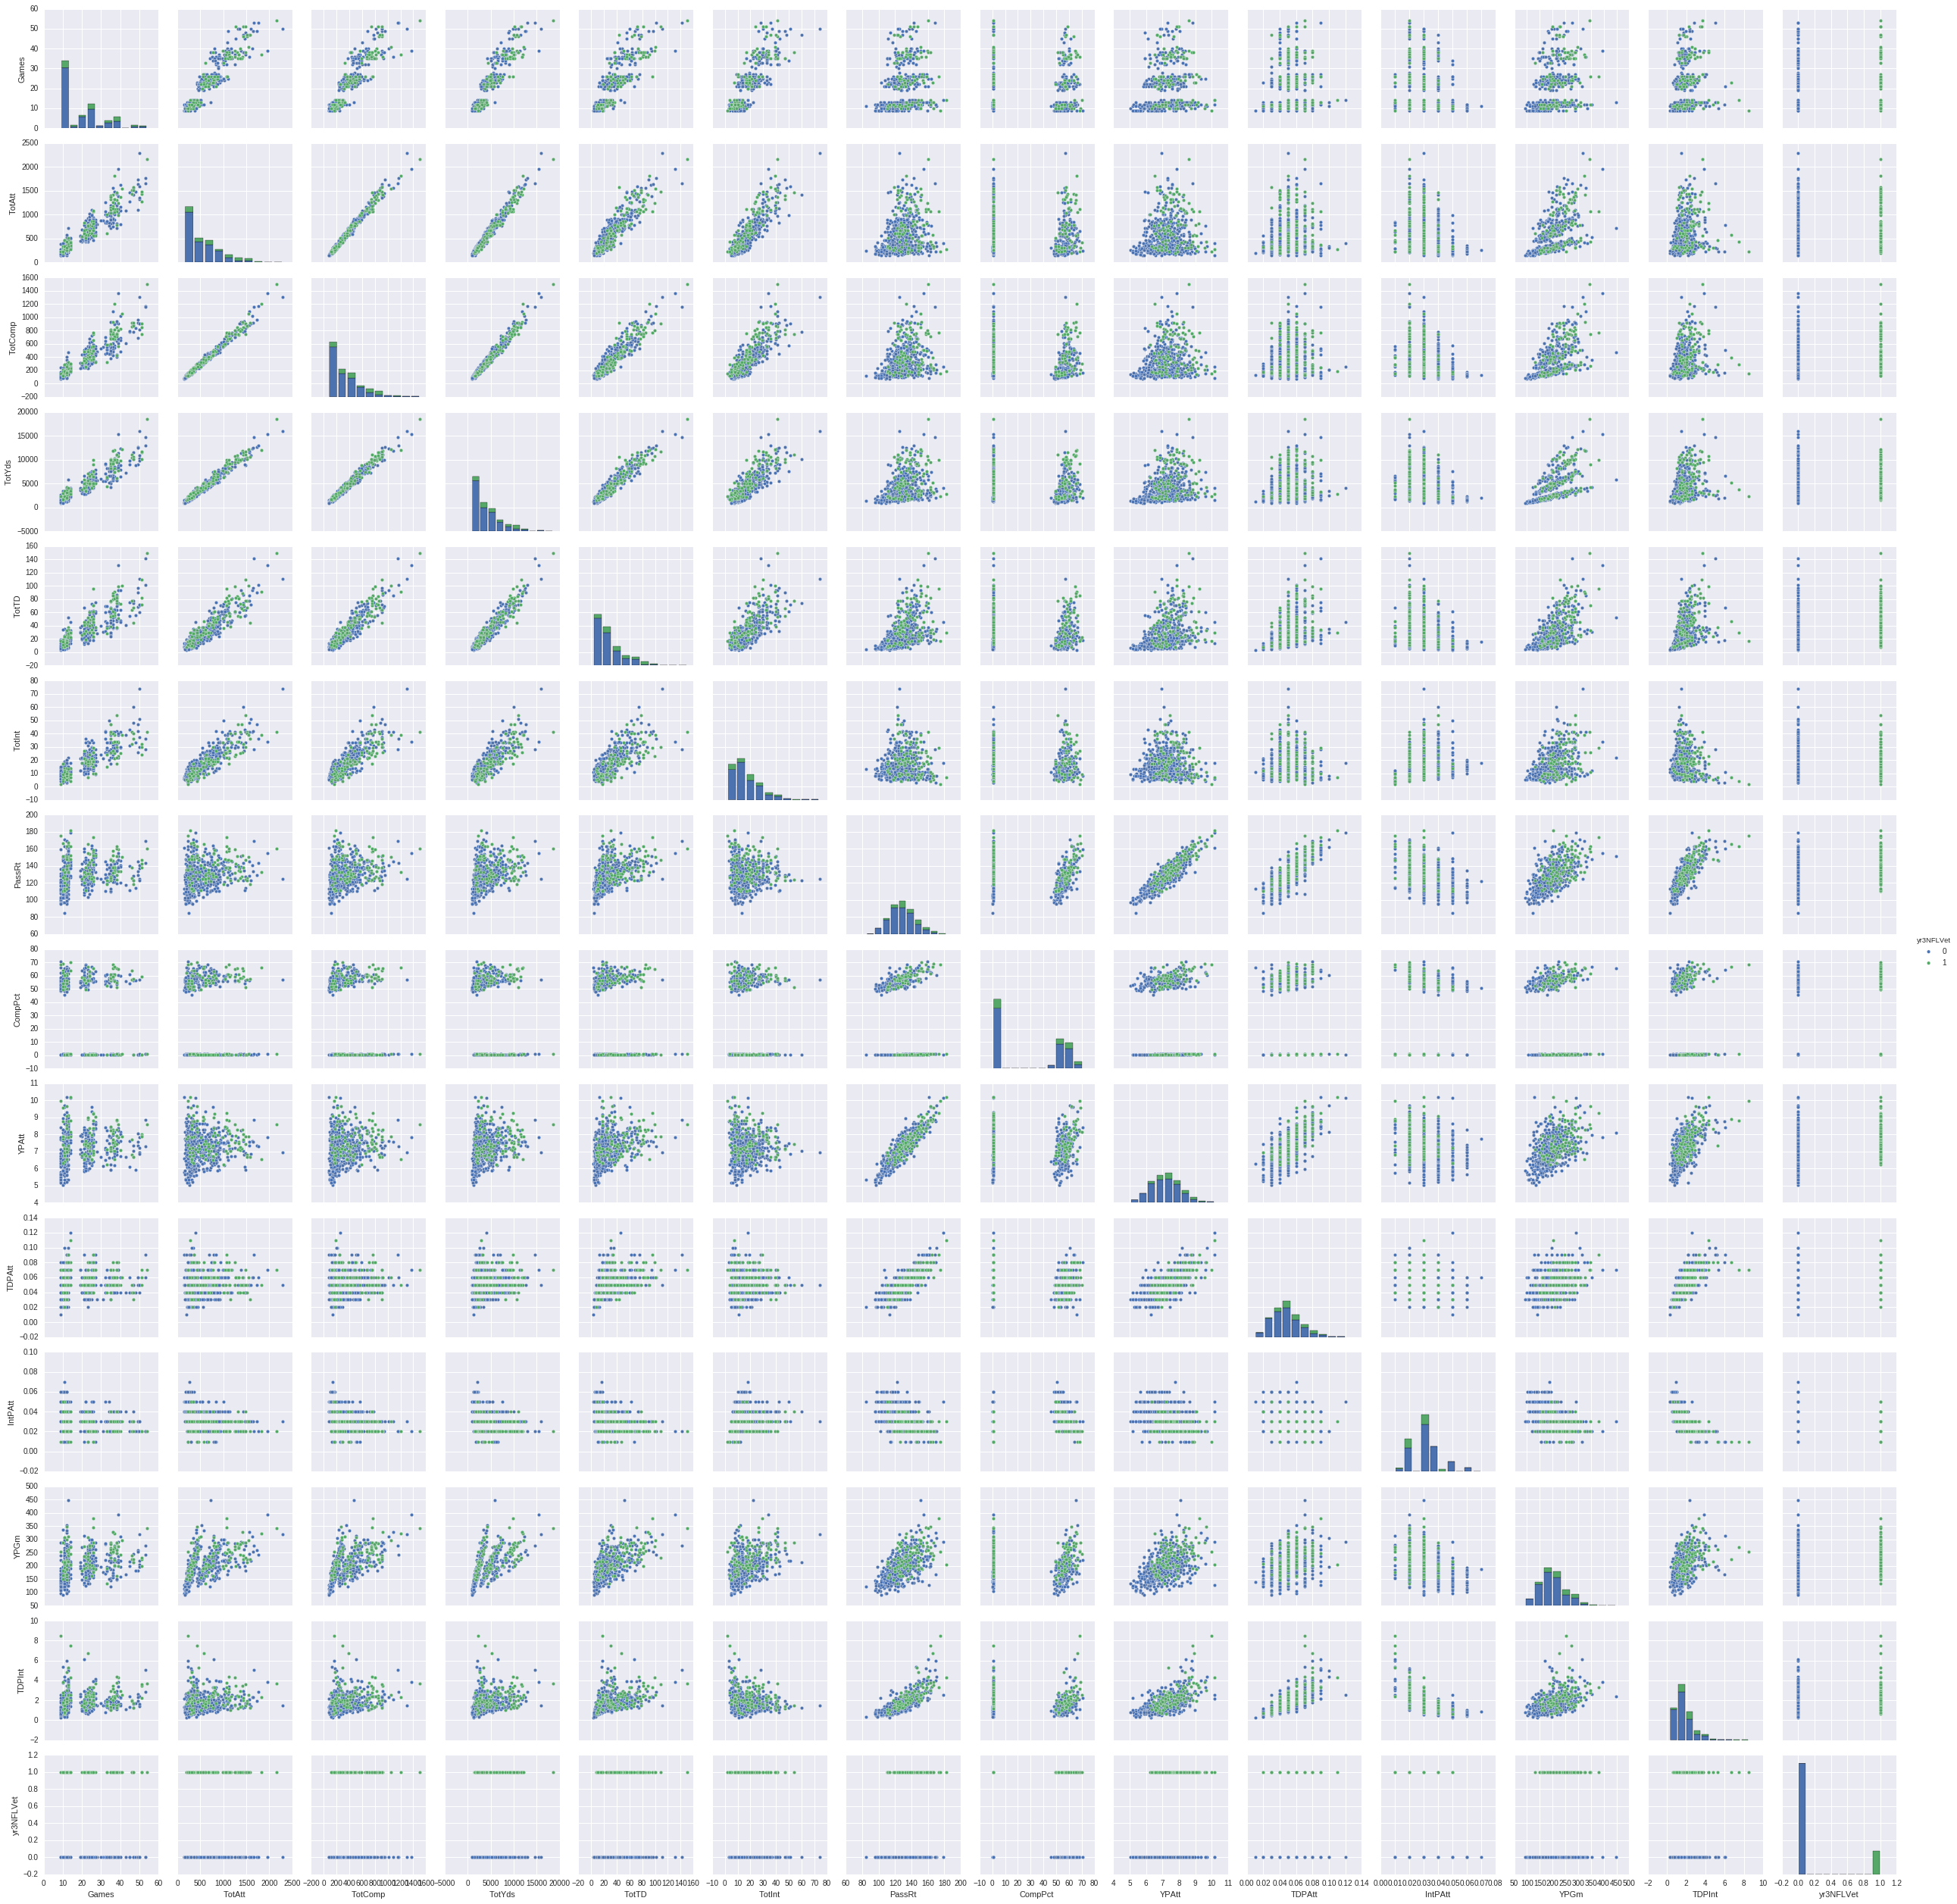

In [38]:
sn.pairplot(train,hue = 'yr3NFLVet')

## One Parameter Analysis

Step 1 of model building per Hosmer and Lemeshow (2000)

In [8]:
QBallMod1 = glm('yr3NFLVet ~ Games', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallMod1.summary())     

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      561
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -246.88
Date:                Mon, 01 Aug 2016   Deviance:                       493.75
Time:                        18:58:56   Pearson chi2:                     560.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.6484      0.254    -10.419      0.000        -3.147    -2.150
Games          0.0498      0.010      5.193      0.0

In [9]:
QBallMod1 = glm('yr3NFLVet ~ CompPct', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallMod1.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      561
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -255.09
Date:                Mon, 01 Aug 2016   Deviance:                       510.18
Time:                        18:59:04   Pearson chi2:                     565.
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.9554      0.179    -10.948      0.000        -2.305    -1.605
CompPct        0.0127      0.004      3.170      0.0

In [15]:
QBallMod1 = glm('yr3NFLVet ~ YPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallMod1.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      561
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -243.61
Date:                Mon, 01 Aug 2016   Deviance:                       487.23
Time:                        19:03:56   Pearson chi2:                     545.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.8623      0.981     -6.996      0.000        -8.785    -4.940
YPAtt          0.7148      0.128      5.564      0.0

In [16]:
QBallMod1 = glm('yr3NFLVet ~ PassRt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallMod1.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      561
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -239.97
Date:                Mon, 01 Aug 2016   Deviance:                       479.93
Time:                        19:04:03   Pearson chi2:                     549.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.5563      1.010     -7.481      0.000        -9.536    -5.577
PassRt         0.0451      0.007      6.117      0.0

In [17]:
QBallMod1 = glm('yr3NFLVet ~ TDPInt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallMod1.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      561
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -239.95
Date:                Mon, 01 Aug 2016   Deviance:                       479.90
Time:                        19:04:08   Pearson chi2:                     537.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.8452      0.256    -11.119      0.000        -3.347    -2.344
TDPInt         0.6479      0.108      5.996      0.0

In [18]:
QBallMod1 = glm('yr3NFLVet ~ YPGm', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallMod1.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      561
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -237.35
Date:                Mon, 01 Aug 2016   Deviance:                       474.71
Time:                        19:04:12   Pearson chi2:                     536.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.6413      0.515     -9.006      0.000        -5.651    -3.631
YPGm           0.0144      0.002      6.423      0.0

In [19]:
QBallMod1 = glm('yr3NFLVet ~ TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallMod1.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      561
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -251.17
Date:                Mon, 01 Aug 2016   Deviance:                       502.33
Time:                        19:04:19   Pearson chi2:                     554.
No. Iterations:                     6                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -3.0462      0.384     -7.937      0.000        -3.798    -2.294
TDPAtt        28.4024      6.708      4.234      0.0

In [20]:
QBallMod1 = glm('yr3NFLVet ~ IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallMod1.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      561
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -245.06
Date:                Mon, 01 Aug 2016   Deviance:                       490.13
Time:                        19:04:21   Pearson chi2:                     548.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3812      0.375      1.017      0.309        -0.353     1.116
IntPAtt      -66.1812     13.023     -5.082      0.0

## Variable Reduction

Using Backwards Elimination with AIC as the metric

In [4]:
QBallFullMod = glm('yr3NFLVet ~ Games+CompPct+YPAtt+PassRt+TDPInt+YPGm+TDPAtt+IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
 
print("AIC =",QBallFullMod.aic)

AIC = 444.82919812


Remove Int/Attempt

In [22]:
QBallMod2 = glm('yr3NFLVet ~ Games+CompPct+YPAtt+PassRt+TDPInt+YPGm+TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallMod2.deviance - QBallFullMod.deviance, QBallFullMod.df_model-QBallMod2.df_model))
print('AIC =',QBallMod2.aic) 

0.436405553608
AIC = 443.434913679


Remove Yards Passing/Game

In [23]:
QBallMod3 = glm('yr3NFLVet ~ Games+CompPct+YPAtt+PassRt+TDPInt+TDPAtt+IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallMod3.deviance - QBallFullMod.deviance, QBallFullMod.df_model-QBallMod3.df_model))
print('AIC =',QBallMod3.aic)

0.0045561588859
AIC = 450.876893077


Remove TD/Attempt

In [24]:
QBallMod4 = glm('yr3NFLVet ~Games+CompPct+YPAtt+PassRt+TDPInt+YPGm+IntPAtt ', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallMod4.deviance - QBallFullMod.deviance, QBallFullMod.df_model-QBallMod4.df_model))
print('AIC =',QBallMod4.aic)

0.262580850157
AIC = 444.084296992


Remove TD/Int

In [25]:
QBallMod5 = glm('yr3NFLVet ~ Games+CompPct+YPAtt+PassRt+YPGm+TDPAtt+IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallMod5.deviance - QBallFullMod.deviance, QBallFullMod.df_model-QBallMod5.df_model))
print('AIC =',QBallMod5.aic)

0.118589689963
AIC = 445.265046893


Remove Passer Rating

In [26]:
QBallMod6 = glm('yr3NFLVet ~ Games+CompPct+YPAtt+TDPInt+YPGm+TDPAtt+IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallMod6.deviance - QBallFullMod.deviance, QBallFullMod.df_model-QBallMod6.df_model))
print('AIC =',QBallMod6.aic)

0.911942503398
AIC = 442.841427982


Remove Yds/Attempt

In [27]:
QBallMod7 = glm('yr3NFLVet ~ Games+CompPct+PassRt+TDPInt+YPGm+TDPAtt+IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallMod7.deviance - QBallFullMod.deviance, QBallFullMod.df_model-QBallMod7.df_model)) 
print('AIC =',QBallMod7.aic)

0.232781712739
AIC = 444.252981299


Remove Completion Percentage

In [28]:
QBallMod8 = glm('yr3NFLVet ~ Games+YPAtt+PassRt+TDPInt+YPGm+TDPAtt+IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print("AIC =",QBallMod8.aic)

AIC = 455.531684704


Remove Games

In [29]:
QBallMod9 = glm('yr3NFLVet ~ CompPct+YPAtt+PassRt+TDPInt+YPGm+TDPAtt+IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print("AIC =",QBallMod9.aic)

AIC = 455.408418711


Passer Rating is eliminated.  Refit the reduced model removing PassRt.  Base AIC is now 442.84

In [30]:
QBallRed1 = glm('yr3NFLVet ~ Games+CompPct+YPAtt+TDPInt+YPGm+TDPAtt+IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed1.aic)

AIC = 442.841427982


Remove Passing Yds/Game from reduced model

In [31]:
QBallRed1_2 = glm('yr3NFLVet ~Games+CompPct+YPAtt+TDPInt+TDPAtt+IntPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed1_2.aic)

AIC = 449.971535434


Remove TD/Int from reduced model

In [32]:
QBallRed1_3 = glm('yr3NFLVet ~Games+CompPct+YPAtt+YPGm+TDPAtt+IntPAtt ', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed1_3.aic)

AIC = 443.299706564


Remove Interceptions/Attempt from reduced model

In [6]:
QBallRed1_4 = glm('yr3NFLVet ~Games+CompPct+YPAtt+TDPInt+YPGm+TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed1_4.aic)

AIC = 441.445776084


Remove Yards per Attempt from reduced model

In [7]:
QBallRed1_5 = glm('yr3NFLVet ~Games+CompPct+TDPInt+YPGm+TDPAtt+IntPAtt ', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed1_5.aic)

AIC = 444.830935176


Remove Completion Percentage from reduced model

In [8]:
QBallRed1_6 = glm('yr3NFLVet ~Games+YPAtt+TDPInt+YPGm+TDPAtt+IntPAtt ', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed1_6.aic)

AIC = 454.642921087


Remove Games from reduced model

In [9]:
QBallRed1_7 = glm('yr3NFLVet ~CompPct+YPAtt+TDPInt+YPGm+TDPAtt+IntPAtt ', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed1_7.aic)

AIC = 453.408566926


New base AIC is 441.446

In [6]:
QBallRed1_4 = glm('yr3NFLVet ~Games+CompPct+YPAtt+TDPInt+YPGm+TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed1_4.aic)

AIC = 441.445776084


In [18]:
QBallRed2_1 = glm('yr3NFLVet ~Games+CompPct+YPAtt+TDPInt+YPGm', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed2_1.aic)

AIC = 443.052450142


In [19]:
QBallRed2_2 = glm('yr3NFLVet ~Games+CompPct+YPAtt+TDPInt+TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed2_2.aic)

AIC = 449.27769348


In [20]:
QBallRed2_3 = glm('yr3NFLVet ~Games+CompPct+YPAtt+YPGm+TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed2_3.aic)

AIC = 450.769462022


In [21]:
QBallRed2_4 = glm('yr3NFLVet ~Games+CompPct+TDPInt+YPGm+TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed2_4.aic)

AIC = 443.215874848


In [22]:
QBallRed2_5 = glm('yr3NFLVet ~Games+YPAtt+TDPInt+YPGm+TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed2_5.aic)

AIC = 453.309755645


In [23]:
QBallRed2_6 = glm('yr3NFLVet ~CompPct+YPAtt+TDPInt+YPGm+TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print('AIC =',QBallRed2_6.aic)

AIC = 453.182264862


In [24]:
QBallRed1_4 = glm('yr3NFLVet ~Games+CompPct+YPAtt+TDPInt+YPGm+TDPAtt', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallRed1_4.summary())
print('AIC =',QBallRed1_4.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      556
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -213.72
Date:                Mon, 01 Aug 2016   Deviance:                       427.45
Time:                        22:11:35   Pearson chi2:                     530.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.6700      1.319     -5.813      0.000       -10.256    -5.084
Games          0.0398      0.011      3.725      0.0

Will remove Yds/Attempt and TD/Attempt given the p-values

In [4]:
QBallRedFinal = glm('yr3NFLVet ~Games+CompPct+TDPInt+YPGm', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallRedFinal.summary())
print('AIC =',QBallRedFinal.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      558
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -216.15
Date:                Wed, 03 Aug 2016   Deviance:                       432.29
Time:                        07:57:43   Pearson chi2:                     524.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -5.8072      0.602     -9.653      0.000        -6.986    -4.628
Games          0.0384      0.011      3.618      0.0

Checking for 2nd order interaction effects shows that the simpler linear model is adequate

In [27]:
QBallRedInt = glm('yr3NFLVet~(Games+CompPct+TDPInt+YPGm)**2 ', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallRedFinal.deviance - QBallRedInt.deviance, QBallRedInt.df_model-QBallRedFinal.df_model))

0.53421396767


Checking for Quadratic Effects shows that the linear model is adequate

In [28]:
QBallQ2 = glm('yr3NFLVet ~ Games+CompPct+TDPInt+YPGm+I(YPGm**2) ', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallRedFinal.deviance - QBallQ2.deviance, QBallQ2.df_model-QBallRedFinal.df_model))

0.0544994132942


In [29]:
QBallQ3 = glm('yr3NFLVet ~ Games+CompPct+TDPInt+I(TDPInt**2)+YPGm ', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallRedFinal.deviance - QBallQ3.deviance, QBallQ3.df_model-QBallRedFinal.df_model))

0.446697577399


In [31]:
QBallQ4 = glm('yr3NFLVet ~ Games+CompPct+I(CompPct**2)+TDPInt+YPGm ', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallRedFinal.deviance - QBallQ4.deviance, QBallQ4.df_model-QBallRedFinal.df_model))

0.658409504746


In [32]:
QBallQ4 = glm('yr3NFLVet ~ Games+I(Games**2)+CompPct+TDPInt+YPGm', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(chi2.sf(QBallRedFinal.deviance - QBallQ4.deviance, QBallQ4.df_model-QBallRedFinal.df_model))

0.624584444096


Here is the final non-regularized model.

In [5]:
QBallRedFinal = glm('yr3NFLVet ~Games+CompPct+TDPInt+YPGm', data= train,family = sm.families.Binomial(sm.families.links.logit)).fit()
print(QBallRedFinal.summary())
print('AIC =',QBallRedFinal.aic)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                            GLM   Df Residuals:                      558
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -216.15
Date:                Wed, 03 Aug 2016   Deviance:                       432.29
Time:                        08:04:46   Pearson chi2:                     524.
No. Iterations:                     7                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -5.8072      0.602     -9.653      0.000        -6.986    -4.628
Games          0.0384      0.011      3.618      0.0

In [40]:
from patsy import dmatrices
yLR,XLR = dmatrices('yr3NFLVet ~ Games+CompPct+TDPInt+YPGm',data= train,return_type='dataframe')
clf_LR = sm.Logit(yLR,XLR)
result = clf_LR.fit()
print(result.summary())
yLRTest,XLRTest = dmatrices('yr3NFLVet ~ Games+CompPct+TDPInt+YPGm',data= test,return_type='dataframe')

Optimization terminated successfully.
         Current function value: 0.383917
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              yr3NFLVet   No. Observations:                  563
Model:                          Logit   Df Residuals:                      558
Method:                           MLE   Df Model:                            4
Date:                Thu, 04 Aug 2016   Pseudo R-squ.:                  0.1695
Time:                        22:16:22   Log-Likelihood:                -216.15
converged:                       True   LL-Null:                       -260.26
                                        LLR p-value:                 3.124e-18
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -5.8072      0.602     -9.653      0.000        -6.986    -4.628
Games          0.0384      0.

In [41]:
yPredict = result.predict(XLRTest)               


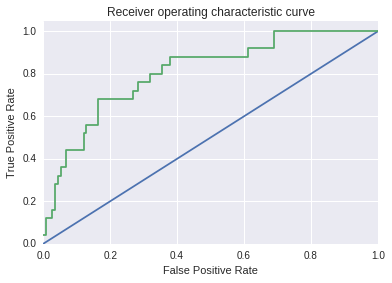

In [21]:
fprLR, tprLR, _ = roc_curve(yLRTest, result.predict(XLRTest))
   
plt.figure()
x = [0,1]
y = [0,1]
plt.plot(x,y)
plt.plot(fprLR, tprLR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show() 

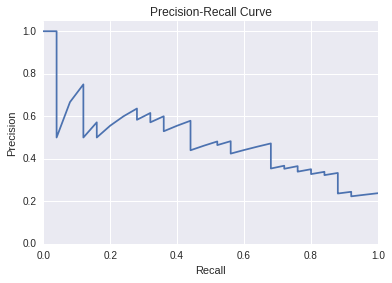

In [12]:
precisionLR, recallLR, _ = precision_recall_curve(yLRTest, result.predict(XLRTest))
plt.figure()
plt.plot(recallLR, precisionLR)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show() 

In [13]:
clf_lf = LogisticRegression()
#clf_rf.fit(X_trainStd, y_train)
param_grid = {
    "penalty": ['l1','l2'],
    "C": [1e-09,1e-06,1e-03,0.01,0.1,1,10,100]
    }
CV_lf = GridSearchCV(estimator=clf_lf, param_grid=param_grid, cv= 5)
CV_lf.fit(X_trainStd, y_train)
print(CV_lf.best_estimator_)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


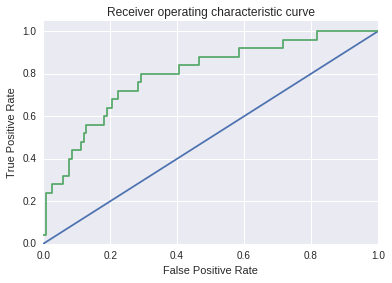

In [22]:
fprLF, tprLF, _ = roc_curve(y_test, CV_lf.predict_proba(X_testStd)[:,1])
   
plt.figure()
x = [0,1]
y = [0,1]
plt.plot(x,y)
plt.plot(fprLF, tprLF)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show() 

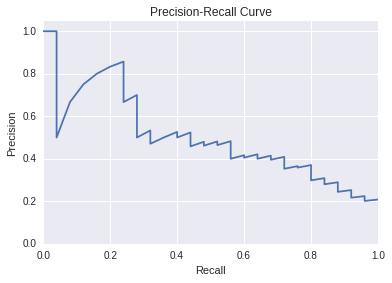

In [14]:
precisionLF, recallLF, _ = precision_recall_curve(y_test, CV_lf.predict_proba(X_testStd)[:,1])
plt.figure()
plt.plot(recallLF, precisionLF)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show() 

In [34]:
clf_rf = RandomForestClassifier()
#clf_rf.fit(X_trainStd, y_train)
param_grid = {
    "n_estimators": [100,250,500,1000],
    "max_features": ['auto','sqrt','log2'],
    "max_depth"   : [1, 3, 5,6,7,8]
    }
CV_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv= 5,scoring = 'recall')
CV_rf.fit(X_trainStd, y_train)
print(CV_rf.best_estimator_)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [39]:
print(CV_rf.best_score_)

0.183682340843


In [42]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1,1e-1,1e-2,1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]},{'kernel': ['linear'], 'C': [1, 10, 100, 1000]},{'kernel':['poly'],'degree':[1,2,3]}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
 
    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_trainStd, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall

Best parameters set found on development set:

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Grid scores on development set:

0.041 (+/-0.020) for {'kernel': 'rbf', 'gamma': 1, 'C': 1}
0.133 (+/-0.026) for {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
0.000 (+/-0.000) for {'kernel': 'rbf', 'gamma': 0.01, 'C': 1}
0.000 (+/-0.000) for {'kernel': 'rbf', 'gamma': 0.001, 'C': 1}
0.000 (+/-0.000) for {'kernel': 'rbf', 'gamma': 0.0001, 'C': 1}
0.143 (+/-0.047) for {'kernel': 'rbf', 'gamma': 1, 'C': 10}
0.234 (+/-0.025) for {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
0.041 (+/-0.019) for {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
0.000 (+/-0.000) for {'kernel': 'rbf', 'gamma': 0.001, 'C': 10}
0.000 (+/-0.000) for {'kernel': 'rbf', 'gamma': 0.0001, 'C': 10}
0.143 (+/-0.047) for {'kernel': 'rbf

/home/brianc/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


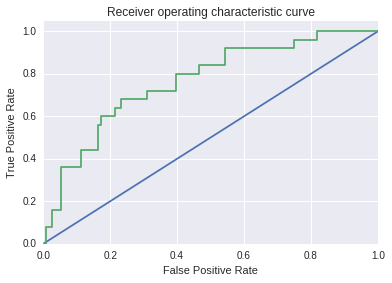

In [23]:
fprRF, tprRF, _ = roc_curve(y_test, CV_rf.predict_proba(X_testStd)[:,1])
   
plt.figure()
x = [0,1]
y = [0,1]
plt.plot(x,y)
plt.plot(fprRF, tprRF)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show() 

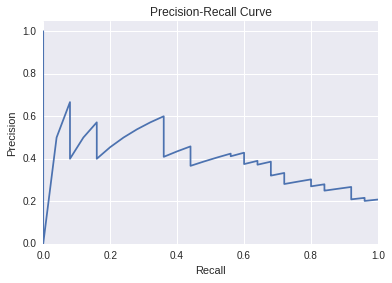

In [17]:
precisionRF, recallRF, _ = precision_recall_curve(y_test, CV_rf.predict_proba(X_testStd)[:,1])
plt.figure()
plt.plot(recallRF, precisionRF)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show() 

In [18]:
clf_knn = KNeighborsClassifier()
#clf_rf.fit(X_trainStd, y_train)
param_grid = {
    "n_neighbors": [1,2,3,4,5,6,7,8,9,10]
    }
CV_knn = GridSearchCV(estimator=clf_knn, param_grid=param_grid, cv= 5)
CV_knn.fit(X_trainStd, y_train)
print(CV_knn.best_estimator_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')


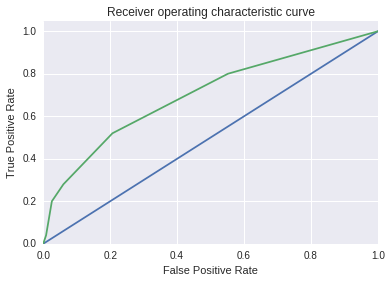

In [24]:
fprKNN, tprKNN, _ = roc_curve(y_test, CV_knn.predict_proba(X_testStd)[:,1])
   
plt.figure()
x = [0,1]
y = [0,1]
plt.plot(x,y)
plt.plot(fprKNN, tprKNN)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.show() 

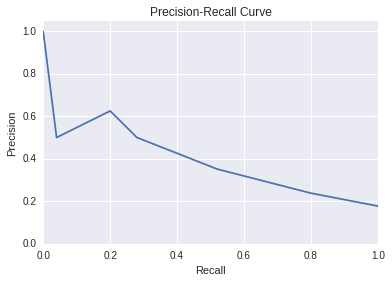

In [19]:
precisionKNN, recallKNN, _ = precision_recall_curve(y_test, CV_knn.predict_proba(X_testStd)[:,1])
plt.figure()
plt.plot(recallKNN, precisionKNN)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show() 

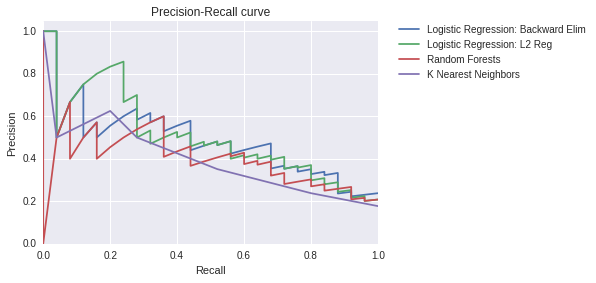

In [25]:
plt.figure()
plt.plot(recallLR, precisionLR,label = 'Logistic Regression: Backward Elim')
plt.plot(recallLF, precisionLF,label = 'Logistic Regression: L2 Reg')
plt.plot(recallRF, precisionRF, label = 'Random Forests')
plt.plot(recallKNN, precisionKNN, label = 'K Nearest Neighbors')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show() 

In [31]:
print(average_precision_score(yLRTest, result.predict(XLRTest)>= 0.50))
print(average_precision_score(y_test, CV_lf.predict_proba(X_testStd)[:,1]>=0.50))
print(average_precision_score(y_test, CV_rf.predict_proba(X_testStd)[:,1]>=0.50))
print(average_precision_score(y_test, CV_knn.predict_proba(X_testStd)[:,1]>=0.50))

0.388014184397
0.562375886525
0.321560283688
0.453829787234


In [32]:
print(precision_score(yLRTest, result.predict(XLRTest)>= 0.50))
print(precision_score(y_test, CV_lf.predict_proba(X_testStd)[:,1]>=0.50))
print(precision_score(y_test, CV_rf.predict_proba(X_testStd)[:,1]>=0.50))
print(precision_score(y_test, CV_knn.predict_proba(X_testStd)[:,1]>=0.50))

0.5
0.75
0.4
0.5


In [33]:
print(recall_score(yLRTest, result.predict(XLRTest)>= 0.50))
print(recall_score(y_test, CV_lf.predict_proba(X_testStd)[:,1]>=0.50))
print(recall_score(y_test, CV_rf.predict_proba(X_testStd)[:,1]>=0.50))
print(recall_score(y_test, CV_knn.predict_proba(X_testStd)[:,1]>=0.50))

0.12
0.24
0.08
0.28


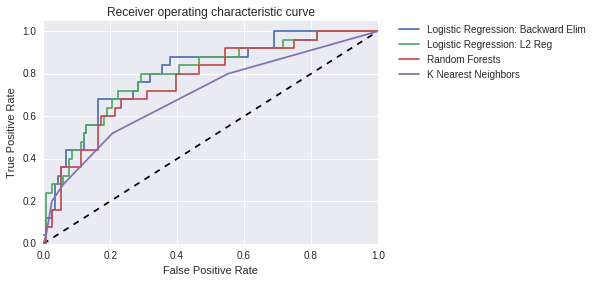

In [26]:
plt.figure()
x = [0,1]
y = [0,1]
plt.plot(x,y, 'k',ls='--')
plt.plot(fprLR, tprLR,label = 'Logistic Regression: Backward Elim')
plt.plot(fprLF, tprLF,label = 'Logistic Regression: L2 Reg')
plt.plot(fprRF, tprRF, label = 'Random Forests')
plt.plot(fprKNN, tprKNN, label = 'K Nearest Neighbors')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show() 

In [27]:
print(auc(fprLR,tprLR))
print(auc(fprLF,tprLF))
print(auc(fprRF,tprRF))
print(auc(fprKNN,tprKNN))

0.806551724138
0.795862068966
0.764482758621
0.700172413793


Confustion Matrix Code

In [135]:
# Source:http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted NFL Success', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True NFL Success', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

Confusion Matrix for Logistic Regression using Backwards Elimination

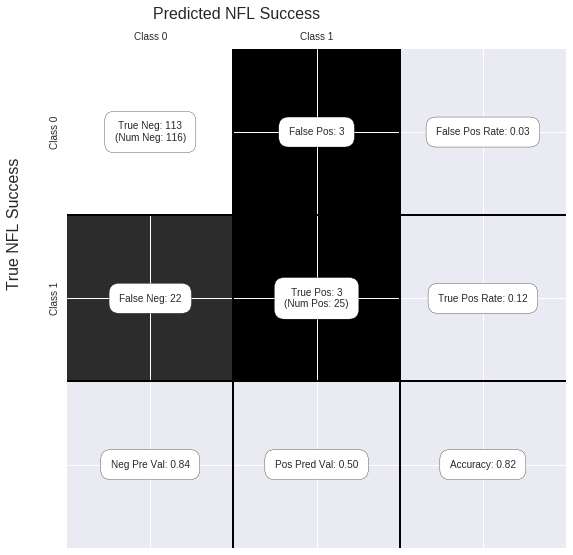

In [136]:
C = confusion_matrix(yLRTest, result.predict(XLRTest)>= 0.50)
show_confusion_matrix(C, ['Class 0', 'Class 1'])

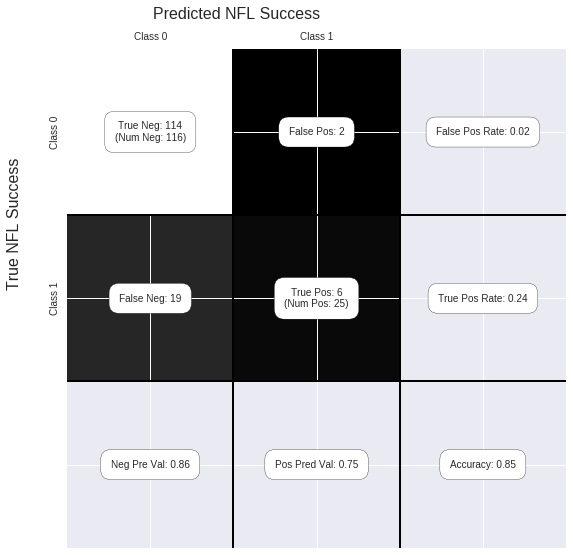

In [137]:
C = confusion_matrix(y_test, CV_lf.predict_proba(X_testStd)[:,1]>=0.50)
show_confusion_matrix(C, ['Class 0', 'Class 1'])

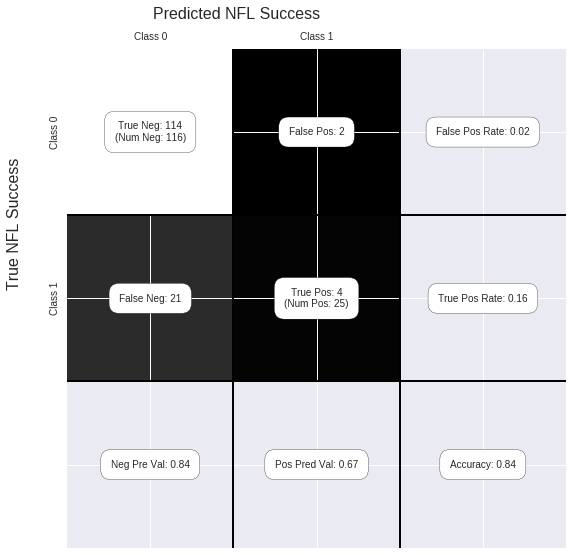

In [138]:
C = confusion_matrix(y_test, CV_rf.predict_proba(X_testStd)[:,1]>=0.50)
show_confusion_matrix(C, ['Class 0', 'Class 1'])

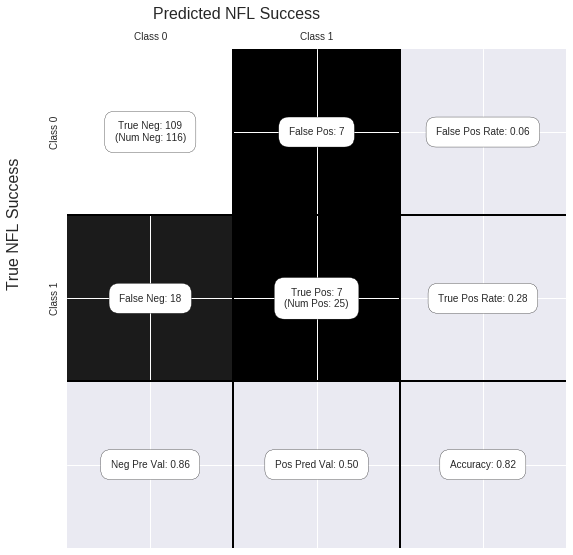

In [139]:
C = confusion_matrix(y_test, CV_knn.predict_proba(X_testStd)[:,1]>=0.50)
show_confusion_matrix(C, ['Class 0', 'Class 1'])